# Support Vector Machines: Churn Analysis

Let's look at a classification example in Spark MLLib.  We are going to look at some telecom data to see whether or not a customer "churned" or not.


In [63]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/spark
Spark config:
	 executor.memory=2g
	some_property=some_value
	spark.app.name=TestApp
	spark.master=local[*]
	spark.sql.warehouse.dir=/tmp/tmp4qqwku4b
	spark.submit.deployMode=client
	spark.ui.showConsoleProgress=true
Spark UI running on port 4041


## Step 1: Load the data

In [64]:
%%time
dataset = spark.read.csv("/data/churn/telco.csv.gz", header=True, inferSchema=True)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 301 ms


In [65]:
print("read {:,} records".format(dataset.count()))

dataset.printSchema()

read 7,043 records
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: integer (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: integer (nullable = true)
 |-- MultipleLines: integer (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: integer (nullable = true)
 |-- OnlineBackup: integer (nullable = true)
 |-- DeviceProtection: integer (nullable = true)
 |-- TechSupport: integer (nullable = true)
 |-- StreamingTV: integer (nullable = true)
 |-- StreamingMovies: integer (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: integer (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [66]:
## Dataframe show output is not easy to read
# dataset.show()

## pretty print with pandas
## horizontally
# dataset.limit(5).toPandas()

## vertically
dataset.limit(5).toPandas().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,1,0,0,0,0
Dependents,0,0,0,0,0
tenure,1,34,2,45,2
PhoneService,0,1,1,0,1
MultipleLines,0,0,0,0,0
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,0,1,1,1,0


## Step 2 : Basic Analytics of Data

In [67]:
## describe

## following output is hard to read
# dataset.describe().show() 

## use pandas for pretty print
## TODO : convert to pandas ('toPandas')
dataset.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
customerID,7043,None,None,0002-ORFBO,9995-HOTOH
gender,7043,None,None,Female,Male
SeniorCitizen,7043,0.1621468124378816,0.3686116056100135,0,1
Partner,7043,0.4830327985233565,0.49974751071998735,0,1
Dependents,7043,0.2995882436461735,0.4581101675100144,0,1
tenure,7043,32.37114865824223,24.559481023094442,0,72
PhoneService,7043,0.9031662643759761,0.29575223178363513,0,1
MultipleLines,7043,0.42183728524776376,0.49388786554556857,0,1
InternetService,7043,0.0,0.0,0,Fiber optic


In [68]:
## TODO : Distribution by 'Churn'
dataset.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [69]:
## TODO : Distribution by 'ContraCT'
dataset.groupBy('ContraCT').count().show()

+--------------+-----+
|      ContraCT|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



In [70]:
## TODO : Distribution by 'Gender'
dataset.groupBy('Gender').count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+



## Step 3 : Categorical Data

In [71]:
## Define columns
prediction_column = ['Churn']
categorical_columns = ['gender',  'InternetService','Contract','PaymentMethod']
categorical_index = ['gender_index',  'InternetService_index','Contract_index','PaymentMethod_index']


columns = ['SeniorCitizen','PhoneService','Partner','Dependents','tenure','MultipleLines',
           'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
           'StreamingTV','StreamingMovies','PaperlessBilling',
           'MonthlyCharges','TotalCharges']

In [72]:
dataset.select(categorical_columns).show(5)
dataset.select(prediction_column).show(5)


+------+---------------+--------------+--------------------+
|gender|InternetService|      Contract|       PaymentMethod|
+------+---------------+--------------+--------------------+
|Female|            DSL|Month-to-month|    Electronic check|
|  Male|            DSL|      One year|        Mailed check|
|  Male|            DSL|Month-to-month|        Mailed check|
|  Male|            DSL|      One year|Bank transfer (au...|
|Female|    Fiber optic|Month-to-month|    Electronic check|
+------+---------------+--------------+--------------------+
only showing top 5 rows

+-----+
|Churn|
+-----+
|   No|
|   No|
|  Yes|
|   No|
|  Yes|
+-----+
only showing top 5 rows



## Step 4: Deal with Categorical Columns

Let's deal with the categorical columns, including the output

Workflow:
- **Feature Indexers** :  ( category columns --> '*_index' columns)
- **Label indexer** : 'Churn' --> 'indexedLabel'
- **Vector Assembler** : '*_index' columns --> 'features' 
- **Scaler** :  'features' --> 'scaledFeatures'

In [73]:
## handy function to pretty print indexers, scalers, assemblers

from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler, MinMaxScaler

def pretty_print_transformer(transformer):
    if (type(transformer) is StringIndexer) \
        or (type(transformer) is StandardScaler) \
        or (type(transformer) is MinMaxScaler) : \
        return (transformer.__class__.__name__ + " : " + transformer.getInputCol() + ' -> ' +  transformer.getOutputCol())
    
    if type(transformer) is VectorAssembler:
        return (transformer.__class__.__name__ + " : " + str(transformer.getInputCols()) + ' -> ' +  transformer.getOutputCol())
    


In [74]:
## 4.1 - Feature Indexers

from pyspark.ml.feature import StringIndexer

print("indexing categorical columns : ", categorical_columns)

## TODO : create indexers in a loop
## loop through 'categorical_columns'
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="keep")\
            for column in categorical_columns ]

for indexer in indexers:
    print(pretty_print_transformer(indexer))


indexing categorical columns :  ['gender', 'InternetService', 'Contract', 'PaymentMethod']
StringIndexer : gender -> gender_index
StringIndexer : InternetService -> InternetService_index
StringIndexer : Contract -> Contract_index
StringIndexer : PaymentMethod -> PaymentMethod_index


In [75]:
## 4.2 - label indexer

from pyspark.ml.feature import StringIndexer

## TODO : we need to index 'Churn' column too
## Create a String Indexer with inputColumn='Churn' and outputCol='indexedLabel'
labelIndexer = StringIndexer(inputCol="Churn", outputCol="indexedLabel")

print(pretty_print_transformer(labelIndexer))


StringIndexer : Churn -> indexedLabel


In [76]:
## 4.3 - Vector assembler 
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=columns + categorical_index, outputCol="features")

print (pretty_print_transformer(assembler))


VectorAssembler : ['SeniorCitizen', 'PhoneService', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'gender_index', 'InternetService_index', 'Contract_index', 'PaymentMethod_index'] -> features


In [77]:
## 4.5 - Scaler
from pyspark.ml.feature import StandardScaler

## TODO : scale 'features' column into 'scaledFeatures'
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

print (pretty_print_transformer(scaler))

StandardScaler : features -> scaledFeatures


## Step 5: Build the Pipeline
We are going to transform the data using Spark pipeline.

In [78]:
from pyspark.ml import Pipeline

##  with scaler
# stages = indexers + [labelIndexer, assembler,  scaler] 

## without scaler
stages = indexers + [assembler, labelIndexer] 

i = 0
for stage in stages:
    i = i+1
    print ("stage ", i , " : ", pretty_print_transformer(stage))
print()

## TODO : Create a 'Pipeline' passing 'stages' as input
pipeline = Pipeline(stages=stages)

print ("pipeline : ", pipeline.explainParams())

stage  1  :  StringIndexer : gender -> gender_index
stage  2  :  StringIndexer : InternetService -> InternetService_index
stage  3  :  StringIndexer : Contract -> Contract_index
stage  4  :  StringIndexer : PaymentMethod -> PaymentMethod_index
stage  5  :  VectorAssembler : ['SeniorCitizen', 'PhoneService', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'gender_index', 'InternetService_index', 'Contract_index', 'PaymentMethod_index'] -> features
stage  6  :  StringIndexer : Churn -> indexedLabel

pipeline :  stages: a list of pipeline stages (current: [StringIndexer_c2c3e79ee23d, StringIndexer_5f99b6963a1f, StringIndexer_6eefff465f37, StringIndexer_c6f1af4df7af, VectorAssembler_f8bce6c0e38b, StringIndexer_ae59f17bba70])


In [79]:
%%time
## TODO : Run data through the pipeline
## Hint : first call 'fit' and then 'transform'
processed_data = pipeline.fit(dataset).transform(dataset)

print ("processed data count ", processed_data.count())

processed data count  7043
CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 816 ms


In [80]:
## pretty print transformed data using pandas
x = processed_data.limit(2).toPandas()
# print horizontally
# x
# print veriticall
x.T

,0,1
customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
SeniorCitizen,0,0
Partner,1,0
Dependents,0,0
tenure,1,34
PhoneService,0,1
MultipleLines,0,0
InternetService,DSL,DSL
OnlineSecurity,0,1


## Step 6: Split into training and test.

In [81]:
## TODO : training=80%,  test=20%
(training, test) = processed_data.randomSplit([.8, .2])

print("training set count : ", training.count())
print("testing set count : ", test.count())

training set count :  5634
testing set count :  1409


## Step 7 - Create SVM Model

In [82]:
from pyspark.ml.classification import LinearSVC

## TODO : create 'LinearSVC' model
##    with labelCol='indexedLabel'
##    with featuresCol='scaledFeatures'
##    with maxIter=100
lsvc = LinearSVC(labelCol="indexedLabel", featuresCol="features", maxIter=100, regParam=0.1)

## Step 8: Train  Linear SVM model

In [83]:
print ("training starting on ", training.count() , " records")

training starting on  5634  records


In [84]:
%%time 

## TODO : train the model
## Hint :    call 'fit' on 'training' data
lsvcModel = lsvc.fit(training)
print ("training done")

training done
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.9 s


In [85]:
import pandas as pd

# Print the coefficients and intercept for linearsSVC
coef = lsvcModel.coefficients

df = pd.DataFrame({'input' : columns + categorical_index, 'coefficient': lsvcModel.coefficients})
print("Intercept: " + str(lsvcModel.intercept))

df
#df.sort_values(by=['input'])

Intercept: -0.05739006235219897


,input,coefficient
0,SeniorCitizen,0.265217
1,PhoneService,-0.120666
2,Partner,-0.051336
3,Dependents,-0.115680
4,tenure,-0.012879
5,MultipleLines,0.155860
6,OnlineSecurity,-0.285226
7,OnlineBackup,-0.173856
8,DeviceProtection,-0.101366
9,TechSupport,-0.339238


## Step 9 : Predict on Test Data

In [86]:
print ("predicting on " , test.count() , " records")

predicting on  1409  records


In [87]:
%%time

## TODO : predict on test data
## Hint : 'transform' on 'test'
predictions_test = lsvcModel.transform(test)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 55.8 ms


In [88]:
predictions_test.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------+---------------------+--------------+-------------------+--------------------+------------+--------------------+----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_index|InternetService_index|Contract_index|PaymentMethod_index|            features|indexedLabel|       rawPrediction|prediction|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+-------

## Step 10: See the evaluation metrics

In [89]:
predictions_test = lsvcModel.transform(test)
predictions_train = lsvcModel.transform(training)

### 10.1 Model Accuracy

In [90]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))


Training set accuracy =  0.8003194888178914
Test set accuracy =  0.8105039034776437


### 10.2 : Confusion matrix

**Interpret the confusion matrix output**

In [91]:
# Confusion matrix
cm = predictions_test.groupBy('Churn').pivot('prediction', [0,1]).count().na.fill(0).orderBy('Churn')
cm.show()

+-----+---+---+
|Churn|  0|  1|
+-----+---+---+
|   No|955| 80|
|  Yes|187|187|
+-----+---+---+



[]

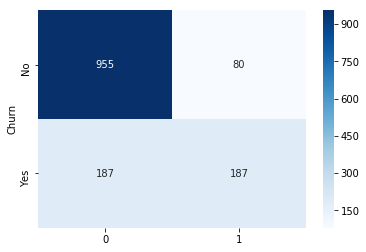

In [92]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("Churn", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True,  fmt=',', cmap="Blues").plot()

### 10.3 - AUC

In [93]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# default metrics for BinaryClassificationEvaluator is 'areaUnderCurve'
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='indexedLabel' )
# print ("default metrics : " ,evaluator.getMetricName())

print("AUC for training: " , evaluator.evaluate(predictions_train))
print("AUC for test : " , evaluator.evaluate(predictions_test))

AUC for training:  0.8350844120006921
AUC for test :  0.8520563693197946


**=> What does AUC mean?** 

## Step 11: Try running without scaling features

In Step-5  we are adding a scaler at the end to normalize the vector.  
Try without scaler.  

Uncomment the following line   
```
#stages = indexers + [assembler, featureIndexer, labelIndexer] 
```

And run the whole notebook (Cell --> Run All)  
Do you see any improvement/degradation in accuracy / AUC ?